### Voy a calcular el parametro de Toomre

Las formulas las saque de Biney & Tremaine - Galactic Dynamics (Libro)

## GADGET

In [7]:
import numpy as np
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2
import density as den
import circular_velocity as vcirc


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')

# path = '/home/omarioni/'
path = '/home/ornela/SimCLUES/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

# path = '/mnt/is2/alejandro/ornella/'
snap = h5py.File(path+'outputs_1/snap_496.h5py', 'r')

# path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
path2 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
    
for i in range(0,3):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'][()]
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'][()]

    pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'][()]
    mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'][()]
    vel  = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Velocities'][()]

    pgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Coordinates'][()]
    mgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Masses'][()]
    
    pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'][()]
    
    z = a0/aexp[0] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])/h
    ystr = (pstr[:,1]-cm[1])/h
    zstr = (pstr[:,2]-cm[2])/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    xgas = (pgas[:,0]-cm[0])/h
    ygas = (pgas[:,1]-cm[1])/h
    zgas = (pgas[:,2]-cm[2])/h

    xdrk = (pdrk[:,0]-cm[0])/h
    ydrk = (pdrk[:,1]-cm[1])/h
    zdrk = (pdrk[:,2]-cm[2])/h

    v_x = vel[:,0] + Ht *xstr/1000.
    v_y = vel[:,1] + Ht *ystr/1000.
    v_z = vel[:,2] + Ht *zstr/1000.

#----------------------masas----------------------------
    mstr = mstr*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h

    r200 = r200/h

    rgal=0.15*r200

    limit = np.where(r < rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = np.cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
    corte,=np.where(r<3.)
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3.*aexp[0])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2)

#----------calculamos las dispersiones de velocidades---------------------
    corte1, = np.where(rn < rgal)
#     corte_bin2, = np.where(rn < 6.)
    
    R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)

    nbin = 50 #20
    rbin, nodos = bines2.rbin1(R, nbin)

    Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
    Vz = vzn[corte1]
    Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R
    

    sigma_z = np.zeros(nbin)
    sigma_R = np.zeros(nbin)
    sigma_t = np.zeros(nbin)
    
    
    for j in range(nbin):
        mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
        n = len(mask)
        Vz_mean = np.mean(Vz[mask])
        Vr_mean = np.mean(Vr[mask])
        Vt_mean = np.mean(Vt[mask])
        
        sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
        sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
        sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)

    
    surf_den, rden = den.surf_density(R,mstr[corte1],nbin)
    
    xngas = e1x*xgas + e1y*ygas + e1z*zgas
    yngas = e2x*xgas + e2y*ygas + e2z*zgas
    zngas = e3x*xgas + e3y*ygas + e3z*zgas
    rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)
    
    xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)
    
    corte_gas = np.where(rgas < rgal)
    corte_drk = np.where(rdrk < rgal)
    
    Rgas = np.sqrt(xngas[corte_gas]**2 + yngas[corte_gas]**2)
    Rdrk = np.sqrt(xndrk[corte_drk]**2 + yndrk[corte_drk]**2)
    
    Rtot= np.concatenate([R, Rgas, Rdrk])
    mtot= np.concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])
    
    vc, r_vc = vcirc.Vc_bin(Rtot, mtot, nbin)
  
    
    data = np.ndarray([nbin,6])
    data[:,0] = rbin
    data[:,1] = sigma_z
    data[:,2] = sigma_R
    data[:,3] = sigma_t
    data[:,4] = surf_den
    data[:,5] = vc
    
    
    
    np.savetxt(path2 + str(vector3[i])+'_sigma_vsR_rgal_test.dat',data, fmt='%12.6f')
#     np.savetxt(path2 + str(vector3[i])+'_sigma_vsR_6kpc.dat',data, fmt='%12.6f')

    
    
#     sigma_x = np.sqrt(sum((vxn-np.mean(vxn))**2)/n)
#     sigma_y = np.sqrt(sum((vyn-np.mean(vyn))**2)/n)
    
#     sigma_t = np.sqrt(sum((Vt - np.mean(Vt))**2)/n)

#         sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)

#         C1 = sigma_z/sigma_total

#--------------------------------------------------------------------------------------------------------------------
#     
# path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
# archivo1 =  open(path2 + str('%s'%vector3[i])+'_sigma_vsR.dat','a')

#     archivo1.write(str('%12.6f'% time) +'\t'+
#                    str('%12.6f'% sigma_x) +'\t'+
#                    str('%12.6f'% sigma_y) +'\t'+
#                    str('%12.6f'% sigma_z) +'\t'+
#                    str('%12.6f'% sigma_R) +'\t'+
#                    str('%12.6f'% sigma_t) +'\n')
#     archivo1.close()     

        
    

## Gasoline

In [11]:
import h5py
import numpy as np
import rotation_mio as rot
import bines2
import circular_velocity as vcirc

a0=1

vector = (1,2,4)
vector2 = ('M31', 'MW','M33')

path2 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'


# path = '/mnt/sersic2/omarioni/'
path = '/home/ornela/SimCLUES/'

snap = h5py.File(path + 'Gasoline/outputs2/snap_1024.h5py', 'r')


for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'][()]
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'][()]
    time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'][()]
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'][()]
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'][()]

    pstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'][()]
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'][()]
    
    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Masses'][()]
    
    pgas = snap['subhalo_00'+ str('%s' %vector[i]) + '/Gas/Coordinates'][()]
    mgas = snap['subhalo_00'+ str('%s' %vector[i]) + '/Gas/Masses'][()]

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    xdrk = pdrk[:,0]-cm[0]
    ydrk = pdrk[:,1]-cm[1]
    zdrk = pdrk[:,2]-cm[2]

    xgas = pgas[:,0]-cm[0]
    ygas = pgas[:,1]-cm[1]
    zgas = pgas[:,2]-cm[2]
#----------------------masas----------------------------
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])


    Mc_str = np.cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*vel[veloc,0])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[veloc,1])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[veloc,2])/sum(mstr[veloc])


#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2)

#----------calculamos las dispersiones de velocidades---------------------
    corte1, = np.where(rn < rgal)
#     corte_bin2, = np.where(rn < 6.)
    
    R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)
    
    nbin = 50 #20
    rbin, nodos = bines2.rbin1(R, nbin)

    Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
    Vz = vzn[corte1]
    Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R
    

    sigma_z = np.zeros(nbin)
    sigma_R = np.zeros(nbin)
    sigma_t = np.zeros(nbin)
    
    
    for j in range(nbin):
        mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
        n = len(mask)
        Vz_mean = np.mean(Vz[mask])
        Vr_mean = np.mean(Vr[mask])
        Vt_mean = np.mean(Vt[mask])
        
        sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
        sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
        sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)

    
    surf_den, rden = den.surf_density(R,mstr[corte1],nbin)
    
    
    xngas = e1x*xgas + e1y*ygas + e1z*zgas
    yngas = e2x*xgas + e2y*ygas + e2z*zgas
    zngas = e3x*xgas + e3y*ygas + e3z*zgas
    rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)
    
    xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)
    
    corte_gas = np.where(rgas < rgal)
    corte_drk = np.where(rdrk < rgal)
    
    Rgas = np.sqrt(xngas[corte_gas]**2 + yngas[corte_gas]**2)
    Rdrk = np.sqrt(xndrk[corte_drk]**2 + yndrk[corte_drk]**2)
    
    Rtot= np.concatenate([R, Rgas, Rdrk])
    mtot= np.concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])
    
    vc, r_vc = vcirc.Vc_bin(Rtot, mtot, nbin)
    
    data = np.ndarray([nbin,6])
    data[:,0] = rbin
    data[:,1] = sigma_z
    data[:,2] = sigma_R
    data[:,3] = sigma_t
    data[:,4] = surf_den
    data[:,5] = vc
    
    
    np.savetxt(path2 + str(vector2[i])+'_sigma_vsR_GS_test.dat',data, fmt='%12.6f')
#     np.savetxt(path2 + str(vector2[i])+'_sigma_vsR_6kpc.dat',data, fmt='%12.6f')


/home/ornela/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/home/ornela/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


In [12]:
import numpy as np
# path = '/home/omarioni/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
M31_gd = np.loadtxt(path + 'M31_sigma_vsR_rgal_test.dat')
rbin_M31gd   = M31_gd[:,0]
sigmaz_M31gd = M31_gd[:,1]
sigmaR_M31gd = M31_gd[:,2]
surden_M31gd = M31_gd[:,4]
Vcirc_M31gd  = M31_gd[:,5]

MW_gd = np.loadtxt(path + 'MW_sigma_vsR_rgal_test.dat')
rbin_MWgd   = MW_gd[:,0]
sigmaz_MWgd = MW_gd[:,1]
sigmaR_MWgd = MW_gd[:,2]
surden_MWgd = MW_gd[:,4]
Vcirc_MWgd  = MW_gd[:,5]

M33_gd = np.loadtxt(path + 'M33_sigma_vsR_rgal_test.dat')
rbin_M33gd   = M33_gd[:,0]
sigmaz_M33gd = M33_gd[:,1]
sigmaR_M33gd = M33_gd[:,2]
surden_M33gd = M33_gd[:,4]
Vcirc_M33gd  = M33_gd[:,5]


M31_gs = np.loadtxt(path + 'M31_sigma_vsR_GS_test.dat')
rbin_M31gs   = M31_gs[:,0]
sigmaz_M31gs = M31_gs[:,1]
sigmaR_M31gs = M31_gs[:,2]
surden_M31gs = M31_gs[:,4]
Vcirc_M31gs  = M31_gs[:,5]

MW_gs = np.loadtxt(path + 'MW_sigma_vsR_GS_test.dat')
rbin_MWgs   = MW_gs[:,0]
sigmaz_MWgs = MW_gs[:,1]
sigmaR_MWgs = MW_gs[:,2]
surden_MWgs = MW_gs[:,4]
Vcirc_MWgs  = MW_gs[:,5]

M33_gs = np.loadtxt(path + 'M33_sigma_vsR_GS_test.dat')
rbin_M33gs   = M33_gs[:,0]
sigmaz_M33gs = M33_gs[:,1]
sigmaR_M33gs = M33_gs[:,2]
surden_M33gs = M31_gs[:,4]
Vcirc_M33gs  = M33_gs[:,5]

### Sigma_z vs R

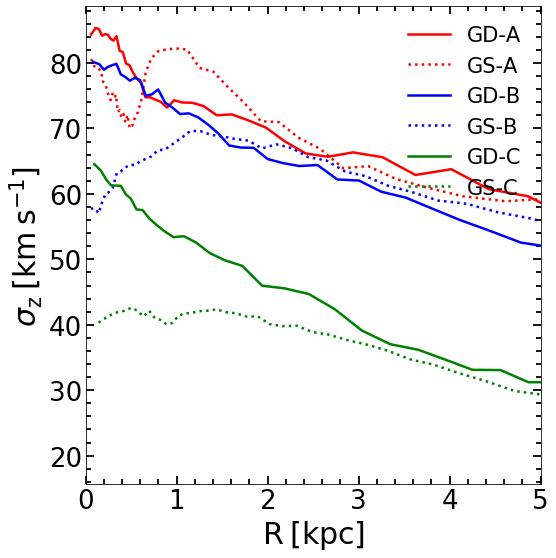

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, sigmaz_M31gd,'-', lw=2.5, color='r', label='GD-A')
ax.plot(rbin_M31gs, sigmaz_M31gs,':', lw=2.5, color='r', label='GS-A')
ax.plot(rbin_MWgd,  sigmaz_MWgd, '-', lw=2.5, color='b', label='GD-B')
ax.plot(rbin_MWgs,  sigmaz_MWgs, ':', lw=2.5, color='b', label='GS-B')
ax.plot(rbin_M33gd, sigmaz_M33gd,'-', lw=2.5, color='g', label='GD-C')
ax.plot(rbin_M33gs, sigmaz_M33gs,':', lw=2.5, color='g', label='GS-C')


ax.set_ylabel(r'$\sigma_{\mathrm{z}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)

# ax.set_ylim(0,0.7)
ax.set_xlim(0,5)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

## Sigma_R vs R

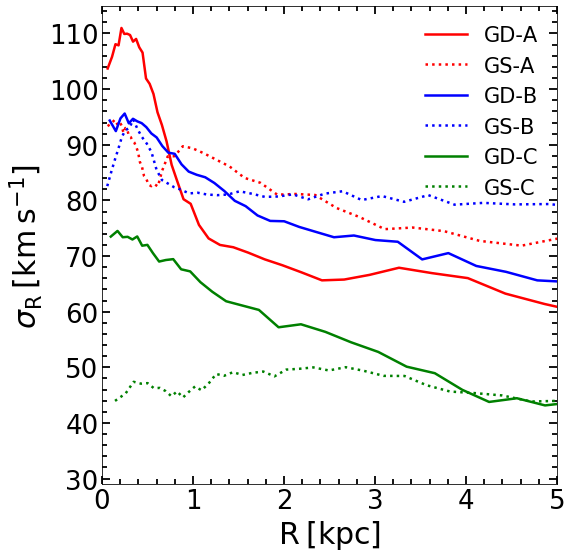

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, sigmaR_M31gd,'-', lw=2.5, color='r', label='GD-A')
ax.plot(rbin_M31gs, sigmaR_M31gs,':', lw=2.5, color='r', label='GS-A')
ax.plot(rbin_MWgd,  sigmaR_MWgd, '-', lw=2.5, color='b', label='GD-B')
ax.plot(rbin_MWgs,  sigmaR_MWgs, ':', lw=2.5, color='b', label='GS-B')
ax.plot(rbin_M33gd, sigmaR_M33gd,'-', lw=2.5, color='g', label='GD-C')
ax.plot(rbin_M33gs, sigmaR_M33gs,':', lw=2.5, color='g', label='GS-C')

# ax.set_yscale('log')
ax.set_ylabel(r'$\sigma_{\mathrm{R}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

### Veloc circ

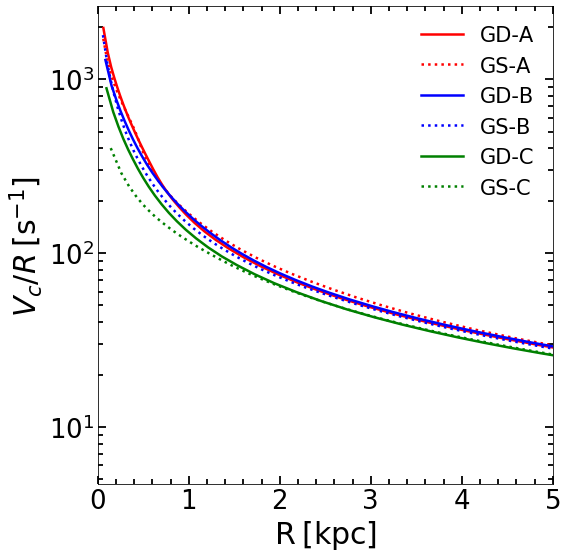

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, Vcirc_M31gd/rbin_M31gd,'-', lw=2.5, color='r', label='GD-A')
ax.plot(rbin_M31gs, Vcirc_M31gs/rbin_M31gs,':', lw=2.5, color='r', label='GS-A')
ax.plot(rbin_MWgd,  Vcirc_MWgd/rbin_MWgd,  '-', lw=2.5, color='b', label='GD-B')
ax.plot(rbin_MWgs,  Vcirc_MWgs/rbin_MWgs,  ':', lw=2.5, color='b', label='GS-B')
ax.plot(rbin_M33gd, Vcirc_M33gd/rbin_M33gd,'-', lw=2.5, color='g', label='GD-C')
ax.plot(rbin_M33gs, Vcirc_M33gs/rbin_M33gs,':', lw=2.5, color='g', label='GS-C')


ax.set_ylabel(r'$V_c/R \: \mathrm{[s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)
# ax.set_xscale('log')
ax.set_yscale('log')


ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

### Density vs R

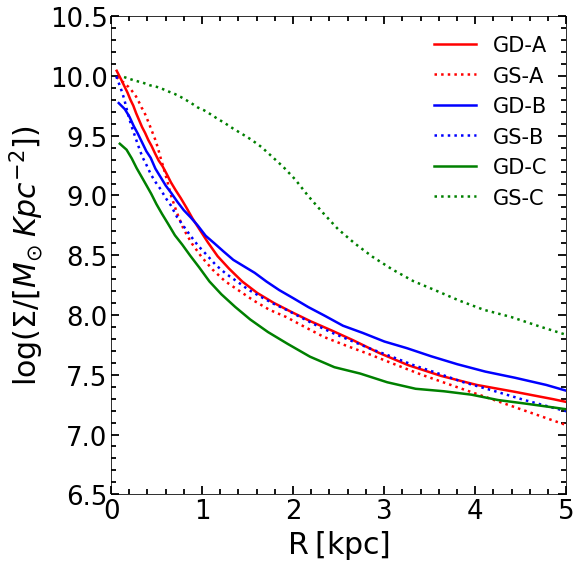

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, np.log10(surden_M31gd),'-', lw=2.5, color='r', label='GD-A')
ax.plot(rbin_M31gs, np.log10(surden_M31gs),':', lw=2.5, color='r', label='GS-A')
ax.plot(rbin_MWgd,  np.log10(surden_MWgd), '-', lw=2.5, color='b', label='GD-B')
ax.plot(rbin_MWgs,  np.log10(surden_MWgs), ':', lw=2.5, color='b', label='GS-B')
ax.plot(rbin_M33gd, np.log10(surden_M33gd),'-', lw=2.5, color='g', label='GD-C')
ax.plot(rbin_M33gs, np.log10(surden_M33gs),':', lw=2.5, color='g', label='GS-C')

# ax.set_yscale('log')
ax.set_ylabel(r'log($\Sigma/[M_{\odot}\:Kpc^{-2}]$)', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
ax.set_ylim(6.5,10.5)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right=True,top=True)
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

### Parametro Toomre 

In [21]:
import numpy as np

def tommre(R, Vcirc, sigma_R, surf_den, G = 4.299e-6):
    
    a0 = (Vcirc/R)**2
    dV = np.diff(Vcirc)
    dR = np.diff(R)
    
    Rmed  = R[:-1] + dR
    deriv = np.interp(R,Rmed,dV/dR)
    
#     plt.plot(Rmed,dV/dR, '-')
#     plt.plot(R,deriv,'-')
    
    k = 2.*a0*(1. + (R/Vcirc) *deriv )
    
#     print k
    Q = sigma_R*np.sqrt(k)/(3.36*G*surf_den)
    
    return Q, np.sqrt(k)

In [22]:
Q_M31gd = tommre(rbin_M31gd, Vcirc_M31gd,sigmaR_M31gd,surden_M31gd)
Q_MWgd  = tommre(rbin_MWgd,  Vcirc_MWgd, sigmaR_MWgd, surden_MWgd)
Q_M33gd = tommre(rbin_M33gd, Vcirc_M33gd,sigmaR_M33gd,surden_M33gd)

Q_M31gs = tommre(rbin_M31gs, Vcirc_M31gs,sigmaR_M31gs,surden_M31gs)
Q_MWgs  = tommre(rbin_MWgs,  Vcirc_MWgs, sigmaR_MWgs, surden_MWgs)
Q_M33gs = tommre(rbin_M33gs, Vcirc_M33gs,sigmaR_M33gs,surden_M33gs)

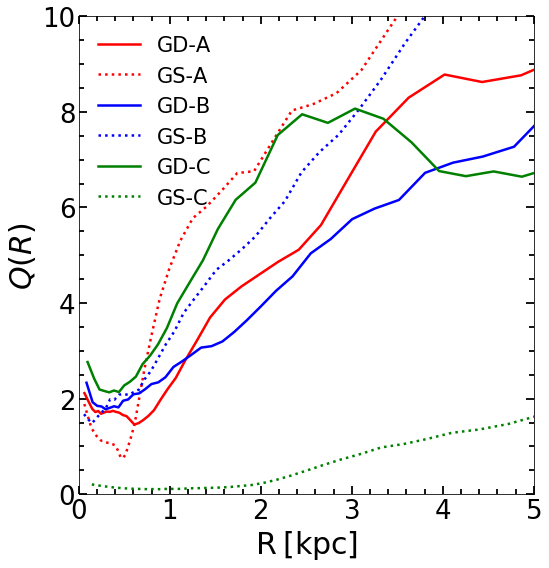

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin_M31gd, Q_M31gd[0],'-', lw=2.5, color='r', label='GD-A')
ax.plot(rbin_M31gs, Q_M31gs[0],':', lw=2.5, color='r', label='GS-A')
ax.plot(rbin_MWgd,  Q_MWgd[0], '-', lw=2.5, color='b', label='GD-B')
ax.plot(rbin_MWgs,  Q_MWgs[0], ':', lw=2.5, color='b', label='GS-B')
ax.plot(rbin_M33gd, Q_M33gd[0],'-', lw=2.5, color='g', label='GD-C')
ax.plot(rbin_M33gs, Q_M33gs[0],':', lw=2.5, color='g', label='GS-C')

# ax.set_yscale('log')
ax.set_ylabel(r'$Q(R)$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,5)
ax.set_ylim(0,10)
# ax.set_xscale('log')


ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax.legend(fontsize=21,frameon=False, loc=2)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()